[目录](./table_of_contents.ipynb)

# 离散贝叶斯滤波器

In [28]:
%matplotlib inline

In [29]:
#format the book
import book_format
book_format.set_style()

卡尔曼滤波器属于一类称为贝叶斯滤波器的滤波器。大多数关于卡尔曼滤波的教科书都给出了贝叶斯公式，也许展示了它是如何融入卡尔曼滤波方程的，但大多数情况下，讨论都停留在一个非常抽象的层次上。这种方法需要对几个数学领域有相当深入的理解。

我将使用另一种方式来诠释这个主题，这得益于Dieter Fox和Sebastian Thrun的工作。它依赖于通过在走廊里追踪一个物体来建立对贝叶斯统计如何工作的直觉——他们用机器人，我用狗。我喜欢狗，它们比机器人更难预测，这给过滤带来了有趣的困难。我能找到的第一个发布的示例似乎是Fox 1999[1]，还有一个更完整的示例是Fox 2003[2]。Sebastian Thrun也在他出色的Udacity课程《人工智能机器人[3]》中使用了这个公式。事实上，如果你喜欢看视频，我强烈建议你暂停阅读这本书，以便学习这门课程的前几节课，然后再回到这本书，更深入地探讨这个主题。

现在让我们用一个简单的思维实验，就像我们用g-h过滤器做的那样，来看看我们如何推理使用概率来过滤和跟踪。

## 追踪一只狗

让我们从一个简单的问题开始。我们有一个对狗友好的工作场所，所以人们带着他们的狗去工作。偶尔，狗会从办公室和走廊里溜达出来。我们希望能够追踪他们。所以在一次黑客马拉松中，有人发明了一种声纳传感器，安装在狗的项圈上。它发出一个信号，监听回声，根据回声返回的速度，我们可以判断狗是否站在敞开的门口。它还能感知狗什么时候走，并报告狗的移动方向。它通过wifi连接网络，每秒钟发送一次更新。

我想追踪我的狗西蒙，所以我把设备绑在它的项圈上然后启动Python，准备写代码在大楼里追踪它。乍一看，这似乎是不可能的。如果我开始监听听西蒙项圈上的传感器，我可能会读到**门**，**走廊**，**走廊**，等等。我怎么用这些信息来确定西蒙的位置?

为了让问题足够简单，便于绘图，我们假设走廊上只有10个位置，我们将编号为0到9，其中1在0的右边。我们还假设走廊是圆形或矩形的。如果你从位置9向右移动，你将处于位置0。 

当我开始监听传感器的声音时，我没有理由相信西蒙在走廊的某个特定位置。在我看来，他可能处于任何位置。有10个位置，所以他在任何位置的概率是1/10。

让我们在NumPy数组中表示他的位置。我可以使用Python列表，但是NumPy数组提供的功能我们很快就会用到。

In [30]:
import numpy as np
belief = np.array([1/10]*10)
print(belief)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


在[贝叶斯统计](https://en.wikipedia.org/wiki/Bayesian_probability)中，这被称为[*prior*](https://en.wikipedia.org/wiki/Prior_probability)。它是在包含测量值或其他信息之前的概率。更完整地说，这被称为“先验概率分布”。[*概率分布*](https://en.wikipedia.org/wiki/Probability_distribution)是一个事件的所有可能概率的集合。概率分布的和总是1，因为一定会发生;这个分布列出了所有可能的事件和每个事件发生的概率。

我相信你以前用过概率，比如“今天下雨的概率是30%”。最后一段听起来更像是。但贝叶斯统计是概率的一场革命，因为它把概率看作是对单个事件的信念。让我们举个例子。我知道如果我无限次地抛一枚均匀硬币，我将得到50%正面和50%反面。这被称为[*frequentist statistics*](https://en.wikipedia.org/wiki/Frequentist_inference)，以区别于贝叶斯统计。计算基于事件发生的频率。

我再抛一次硬币，让它落在地上。我觉得它是怎么降落的?频率论概率对此没有什么可说的;它仅仅说明50%的抛硬币是正面。在某些方面，给硬币的当前状态赋一个概率是没有意义的。不是正面就是反面，我们不知道是哪一个。贝叶斯认为这是对单个事件的信念，我的信念或知识的强度是50%，这个特定的抛硬币是正面。有些人反对“信念”这个词;信念意味着在没有证据的情况下认为某事是正确的。在这本书中，它总是衡量我们知识的力量。随着学习的深入，我们会学到更多。

贝叶斯统计将过去的信息(之前的信息)考虑在内。我们观察到每100天下4次雨。由此我可以得出明天下雨的概率是1/25。天气预测不是这样做的。如果我知道今天下雨，风暴锋停止了，明天可能会下雨。天气预测是贝叶斯的。

在实践中，统计学家混合使用频率主义和贝叶斯技术。有时找到先验是困难的或不可能的，而频率控制技术则占据主导地位。在这本书中我们可以找到先验。当我说某件事的概率时，我指的是某件事在过去的事件中发生的概率。我用的是贝叶斯方法。
 
现在让我们创建一个走廊的地图。我们把前两扇门放在一起，再把另一扇放远一点。我们将用1表示门，0表示墙:

In [31]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

我开始监听西蒙，从传感器得到的第一个数据是**门**。目前假设传感器总是返回正确的答案。由此我推断他站在一扇门前，但是是哪扇门呢?我没有理由相信他就在第一、第二或第三扇门前。我能做的就是给每扇门分配一个概率。所有门的概率都是相等的，有三扇门，所以我把每扇门的概率定为1/3。

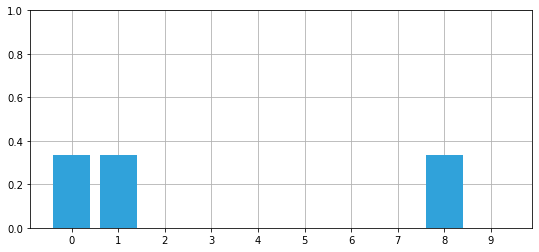

In [32]:
import kf_book.book_plots as book_plots
from kf_book.book_plots import figsize, set_figsize
import matplotlib.pyplot as plt

belief = np.array([1/3, 1/3, 0, 0, 0, 0, 0, 0, 1/3, 0])
book_plots.bar_plot(belief)

这种分布称为[*分类分布*](https://en.wikipedia.org/wiki/Categorical_distribution)，它是描述观察$n$结果的概率的离散分布。这是一个[*多模态分布*](https://en.wikipedia.org/wiki/Multimodal_distribution)，因为我们对狗的位置有多种信念。当然，我们并不是说我们认为他同时在三个不同的地点，只是我们把我们的知识缩小到这三个地点中的一个。我的(贝叶斯)信念是，有33.3%的可能性出现在门0，门1和门8。

这是两个方面的改进。我排除了一些不可能的走廊位置，我对其他位置的信心从10%增加到了33%。这总是会发生的。随着我们知识的提高，概率将接近100%。

简单介绍一下[*mode*](https://en.wikipedia.org/wiki/Mode_%28statistics%29)。给定一个数字列表，例如{1,2,2,2,3,3,4}，*mode*是最常出现的数字。对于这个集合，mode是2。一个分布可以包含多个mode。列表{1,2,2,2,3,3,4,4,4}包含mode2和mode4，因为这两个模式都出现了三次。我们说前一个列表是[*unimodal*](https://en.wikipedia.org/wiki/Unimodality)，后一个列表是*multimodal*。

这种分布的另一个术语是[*直方图*](https://en.wikipedia.org/wiki/Histogram)。直方图以图形的方式描述了一组数字的分布。上面的柱状图是一个直方图。

我在上面的代码中手工编码了“信念”数组。我们如何在代码中实现它?我们用1表示门，用0表示墙，所以我们将走廊变量乘以百分比，就像这样;

In [33]:
belief = hallway * (1/3)
print(belief)

[0.333 0.333 0.    0.    0.    0.    0.    0.    0.333 0.   ]


## 从传感器读数中提取信息


让我们把Python放在一边，稍微考虑一下这个问题。假设我们从西蒙的传感器上读到以下内容:
  * 门
  * 向右移动
  * 门
  
我们能推断出西蒙的位置吗?当然!考虑到走廊的布局，你只能从一个地方获得这个序列，那就是左侧末端。因此，我们可以自信地说，西蒙就在第二个门口。如果这还不清楚，假设西蒙从第二或第三扇门开始。在向右移动后，他的传感器会返回“墙”。这和传感器读数不符，所以我们知道他不是从那里开始的。我们可以对所有剩下的起始位置继续用这个逻辑。唯一的可能性是，他现在就在第二扇门前。我们认为:

In [34]:
belief = np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

我设计了走廊布局和传感器读数，以便快速给出准确的答案。真正的问题并不那么明确。但这应该会触发你的直觉-第一个传感器读数只给了我们很低的概率(0.333)西蒙的位置，但在位置更新和另一个传感器读数后，我们知道更多关于他的位置。你可能会怀疑，如果你的走廊很长，有很多门，经过几次传感器读数和位置更新，我们要么就能知道西蒙在哪里，要么就能把可能性缩小到一小部分。当一组传感器读数只匹配一个到几个起始位置时，这是可能的。

我们现在可以实现这个解决方案，但是让我们考虑这个问题的实际复杂性。

## 传感器噪声


完美的传感器是不存在的。也许，如果西蒙坐在门前抓挠自己，传感器就不会探测到门，或者如果他不是面朝走廊，传感器就会误读。因此，当我得到**门**时，我不能用1/3作为概率。我必须给每扇门分配小于1/3的概率，给每面墙分配一个小概率。类似的

```Python
[.31, .31, .01, .01, .01, .01, .01, .01, .31, .01]
```
乍一看，这似乎是不可避免的。如果传感器有噪声，就会对每一条数据产生怀疑。如果我们总是不确定，我们怎么能得出结论呢?

就像上面的问题一样，答案在于概率。我们已经习惯于给狗的位置分配一个概率信念;现在我们必须考虑由传感器噪声引起的额外不确定性。

假设我们得到一个**门**的读数，并假设测试显示传感器正确的可能性是错误的3倍。我们应该把有门的概率分布乘以3。如果我们这样做，结果将不再是概率分布，但我们将学习如何修正它。

让我们用Python代码来看看。这里我使用变量z来表示度量值。' z '或' y '是文献中用于测量的习惯选择。作为一名程序员，我更喜欢有意义的变量名，但我希望您能够阅读相关文献和/或其他过滤代码，所以现在我将开始介绍这些缩写的名称。

belief: [0.3 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.1]
sum = 1.6000000000000003


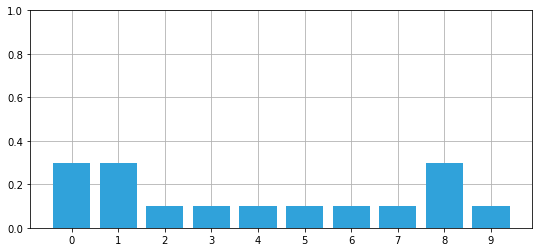

In [35]:
def update_belief(hall, belief, z, correct_scale):
    for i, val in enumerate(hall):
        if val == z:
            belief[i] *= correct_scale

belief = np.array([0.1] * 10)
reading = 1 # 1 is 'door'
update_belief(hallway, belief, z=reading, correct_scale=3.)
print('belief:', belief)
print('sum =', sum(belief))
plt.figure()
book_plots.bar_plot(belief)

这不是一个概率分布，因为它的和不等于1.0。但这个代码基本上是正确的——门的编号(0.3)是墙(0.1)的3倍。我们需要做的就是将结果标准化，使概率正确地和为1.0。标准化是通过将每个元素除以列表中所有元素的和来完成的。NumPy很容易做到这一点:

In [36]:
belief / sum(belief)

array([0.188, 0.188, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.188,
       0.062])

FilterPy通过' normalize '函数实现了这个功能:

```Python
from filterpy.discrete_bayes import normalize
normalize(belief)
```
说“正确概率是错误概率的3倍”有点奇怪。我们在计算概率，所以让我们指定传感器正确的概率，然后计算比例因子。方程是

$$scale =  \frac{prob_{correct}}{prob_{incorrect}} = \frac{prob_{correct}} {1-prob_{correct}}$$

此外，' for '循环也很麻烦。作为一般规则，你将希望避免在NumPy代码中使用' for '循环。NumPy是用C和Fortran实现的，所以如果你避免for循环，结果通常比等价循环快100倍。

我们如何摆脱这个for循环?NumPy允许使用布尔数组为数组建立索引。您可以使用逻辑操作符创建一个布尔数组。我们可以在走廊里找到所有的门

In [37]:
hallway == 1

array([ True,  True, False, False, False, False, False, False,  True,
       False])

 当你使用布尔数组作为另一个数组的索引时，它只返回索引为“True”的元素。因此，我们可以用：
```python
belief[hall==z] *= scale
```
只有等于z的元素才会乘以scale。

教你NumPy超出了这本书的范围。我将使用惯用的NumPy结构，并在第一次展示它们时解释它们。如果你是NumPy的新手，有很多关于如何高效和习惯地使用NumPy的博客文章和视频。
 
这是我们改进的版本:

sum = 1.0
probability of door = 0.1875
probability of wall = 0.06249999999999999


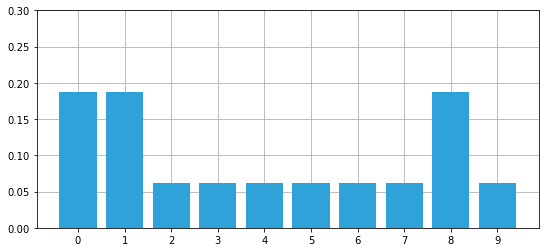

In [38]:
from filterpy.discrete_bayes import normalize

def scaled_update(hall, belief, z, z_prob): 
    scale = z_prob / (1. - z_prob)
    belief[hall==z] *= scale
    normalize(belief)

belief = np.array([0.1] * 10)
scaled_update(hallway, belief, z=1, z_prob=.75)

print('sum =', sum(belief))
print('probability of door =', belief[0])
print('probability of wall =', belief[2])
book_plots.bar_plot(belief, ylim=(0, .3))

我们可以从输出中看到，总和现在是1.0，门和墙的概率仍然是3倍大。这个结果也符合我们的直觉，门的概率必须小于0.333，墙的概率必须大于0.0。最后，它应该符合我们的直觉，我们还没有得到任何信息，让我们区分任何给定的门或墙位置，所以所有的门位置应该有相同的值，墙壁位置也应该是相同的。 
 
这个结果称为[*posterior*](https://en.wikipedia.org/wiki/Posterior_probability)，是*后验概率分布*的缩写。 一个概率分布合并了测量信息之后(后验意味着在此背景下(测量完成)的“之后”)。回顾一下，*先验*是包含测量信息之前的概率分布。

另一个术语是[*可能性*](https://en.wikipedia.org/wiki/Likelihood_function)。当我们计算' belief[hall= z] *= scale '时，我们是在计算每个位置给出测量值的*可能性。可能性不是概率分布，因为它的和不是1。

这些结合起来就得到了方程

$$\mathtt{posterior} = \frac{\mathtt{likelihood} \times \mathtt{prior}}{\mathtt{normalization}}$$ 
 
当我们讨论滤波器的输出时，我们通常将执行预测后的状态称为“先验”或“预测”，而将更新后的状态称为“后验”或“估计状态”。

学习和内化这些术语是非常重要的，因为大多数文献都广泛地使用它们。

' scaled_update() '执行这个计算吗?它的功能。让我把它改写成这样:

In [39]:
def scaled_update(hall, belief, z, z_prob): 
    scale = z_prob / (1. - z_prob)
    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return normalize(likelihood * belief)

这个函数不是完全通用的。它包含了关于走廊的信息，以及如何将测量结果与之匹配。我们总是努力写出一般的函数。在这里，我们将从函数中删除可能性的计算，并要求调用者自己计算可能性。
 
以下是该算法的完整实现:

```python
def update(likelihood, prior):
    return normalize(likelihood * prior)
```

可能性的计算每个问题都不同。例如，传感器可能不只是返回1或0，而是返回0和1之间的一个“浮动”，表示出现在门前面的概率。它可能会使用计算机视觉报告一个斑点形状，然后你就有可能匹配一扇门。它可能使用声纳并返回一个距离读数。在每种情况下，可能性的计算都是不同的。我们将在本书中看到许多这样的例子，并学习如何执行这些计算。

FilterPy implements `update`. Here is the previous example in a fully general form:
FilterPy实现`update`”。下面是上面那个完全通用的例子:

In [40]:
from filterpy.discrete_bayes import update

def lh_hallway(hall, z, z_prob):
    """ compute likelihood that a measurement matches
    positions in the hallway."""
    
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8

    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return likelihood

belief = np.array([0.1] * 10)
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
print(likelihood)
update(likelihood, belief)  

[3. 3. 1. 1. 1. 1. 1. 1. 3. 1.]


array([0.188, 0.188, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.188,
       0.062])

## 结合运动

回想一下，当我们加入一系列测量和运动更新时，我们是多么迅速地找到了一个精确的解决方案。然而，这发生在一个充满完美传感器的虚构世界。我们能否用噪声传感器找到一个精确的解决方案?

不幸的是，答案是否定的。即使传感器读数与极其复杂的走廊地图完全匹配，我们也不能100%确定狗在某个特定位置——毕竟，每个传感器读数都有微小的可能是错误的!当然，在更典型的情况下，大多数传感器读数将是正确的，我们可能接近100%肯定我们的答案，但从来没有100%肯定。这可能看起来很复杂，但让我们继续编写数学程序。

首先让我们来处理一个简单的情况——假设运动传感器是完美的，它报告狗向右移动了一个空间。我们该如何改变我们的“信念”阵列?

我希望经过片刻的思考，我们可以清楚地看到，我们应该把所有的值向右移动一个空格。如果我们之前认为西蒙有50%的机会出现在3号位置，那么在他向右移动一个位置后我们应该相信他有50%的机会出现在4号位置。走廊是圆形的，所以我们将使用模运算来进行移位。 

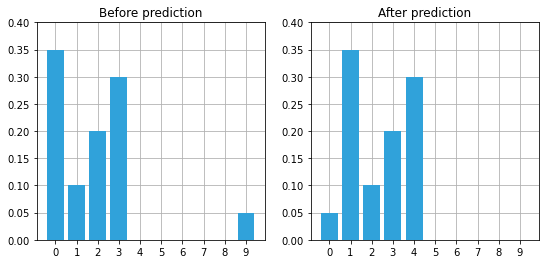

In [41]:
def perfect_predict(belief, move):
    """ move the position by `move` spaces, where positive is 
    to the right, and negative is to the left
    """
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = belief[(i-move) % n]
    return result
        
belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
plt.subplot(121)
book_plots.bar_plot(belief, title='Before prediction', ylim=(0, .4))

belief = perfect_predict(belief, 1)
plt.subplot(122)
book_plots.bar_plot(belief, title='After prediction', ylim=(0, .4))

我们可以看到，我们正确地将所有值向右移动了一个位置，从数组的末尾换行到开头。
 
下一个单元格使它动画，这样你就可以看到它的动作。使用滑块在时间上向前或向后移动。这是模拟西蒙在走廊里来回走动。它还没有纳入新的测量，因此概率分布不会改变形状，只会改变位置。

In [42]:
from ipywidgets import interact, IntSlider

belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
perfect_beliefs = []

for _ in range(20):
    # Simon takes one step to the right
    belief = perfect_predict(belief, 1)
    perfect_beliefs.append(belief)

def simulate(time_step):
    book_plots.bar_plot(perfect_beliefs[time_step], ylim=(0, .4))
    
interact(simulate, time_step=IntSlider(value=0, max=len(perfect_beliefs)-1));

interactive(children=(IntSlider(value=0, description='time_step', max=19), Output()), _dom_classes=('widget-in…

## 术语

让我们暂停一下，回顾一下术语。我在上一章介绍了这个术语，但让我们花点时间来巩固你的知识。
 
*系统*是我们试图建模或过滤的东西。这里的系统是我们的狗。*state*是它的当前配置或值。在这一章中，状态是我们的狗的位置。我们很少知道实际的状态，所以我们说我们的过滤器产生系统的“估计状态”。在实践中，这经常被称为状态，所以要仔细理解上下文。
 
用测量进行预测和更新的一个周期称为状态或系统*evolution*，它是*time evolution*[7]的缩写。另一个术语是*系统传播*。它指的是系统的状态是如何随时间变化的。对于滤波器，时间通常是一个离散的步骤，例如1秒。对于我们的狗追踪器，系统状态是狗的位置，状态演化是经过一段离散时间后的位置。

我们用“过程模型”对系统行为进行建模。在这里，我们的过程模型是，狗在每个时间步骤中移动一个或多个位置。对于狗的行为，这并不是一个特别准确的模型。模型中的误差称为“系统误差”或“过程误差”。

这个预测是我们新的“先验”。随着时间的推移，我们在不知道测量结果的情况下做出了预测。
让我们来看一个例子。目前狗的位置是17米。我们的时间间隔是2秒，而狗的速度是15米/秒。我们预测他两秒钟后会在哪里?
 
$$ \begin{aligned}
\bar x &= 17 + (15*2) \\
&= 47
\end{aligned}$$

我在变量上使用条形图表示它们是先验(预测)。我们可以这样写流程模型的方程:

$$ \bar x_{k+1} = f_x(\bullet) + x_k$$

$x_k$ 当前的位置或状态. 如果狗在 17 m 则 $x_k = 17$.

$f_x(\bullet)$ 是关于x状态传播函数 . 它描述的是 $x_k$ 随时间变化的关系. 在我们的例子中计算方法为 $15 \cdot 2$ ，所以我们这样定义： 

$$f_x(v_x, t) = v_k t$$.

## 为预测添加不确定性

' perfect_predict() '假设测量是完美的，但所有的传感器都有噪声。如果传感器报告说我们的狗移动了一个空间，但实际上它移动了两个空间，或者是零呢?这听起来像是一个无法克服的问题，但让我们模拟一下，看看会发生什么。

假设传感器的运动测量有80%的可能是正确的，10%的可能是右过冲，10%的可能是左过冲。也就是说，如果移动测量值是4(即向右移动4个空格)，那么狗有80%的可能性向右移动4个空格，10%移动3个空格，10%移动5个空格

数组中的每个结果现在都需要包含3种不同情况的概率。例如，考虑移动2。如果我们100%确定狗从位置3开始，那么他有80%的可能是5，有10%的可能是4或6。让我们试着这样编码: 

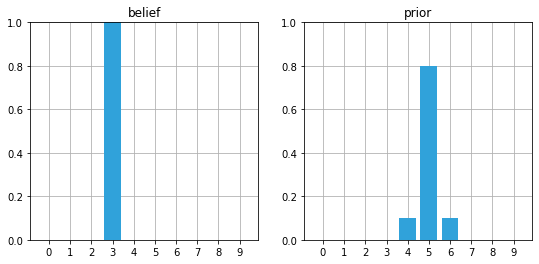

In [43]:
def predict_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = (
            belief[(i-move) % n]   * p_correct +
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)      
    return prior

belief = [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief, prior)

它似乎工作正常。那么当我们的信念不是100%确定的时候会发生什么呢?

array([0.  , 0.  , 0.  , 0.04, 0.38, 0.52, 0.06, 0.  , 0.  , 0.  ])

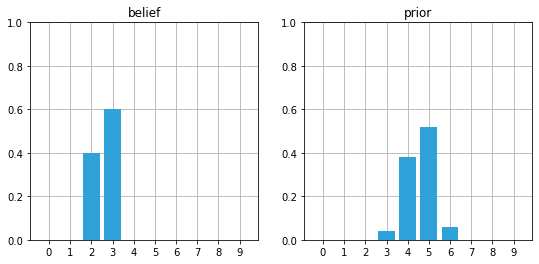

In [44]:
belief = [0, 0, .4, .6, 0, 0, 0, 0, 0, 0]
prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief, prior)
prior

这里的结果更复杂，但你仍然可以在脑子里算出来。0.04是由于0.4的信念可能低于1。0.38是由于以下原因:我们移动了2个位置的概率是80%(0.4 $\乘以$ 0.8)，而我们低于预期的概率是10%(0.6 $\乘以$ 0.1)。超调在这里没有作用，因为如果我们同时超0.4和0.6，就会超过这个位置。**我强烈建议在所有这些都非常清楚之前先做一些例子，因为接下来的很多内容都取决于对这一步的理解**

如果你在执行更新后查看概率，你可能会感到沮丧。在上面的例子中，我们从两个位置的概率为0.4和0.6开始;执行更新后，概率不仅会降低，而且还会散布在整个地图上。

这不是巧合，也不是精心挑选的例子的结果——预测总是如此。如果传感器有噪声，我们在每次预测中都会丢失一些信息。假设我们进行无限次的预测，结果会是什么?如果我们在每一步都丢失信息，那么我们最终将会完全没有信息，我们的概率将平均分布在“信念”数组中。让我们尝试100次迭代。图像跳动起来了，使用滑块改变步数看看又会发生什么？

In [46]:
belief = np.array([1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predict_beliefs = []
    
for i in range(100):
    belief = predict_move(belief, 1, .1, .8, .1)
    predict_beliefs.append(belief)

print('Final Belief:', belief)

# make interactive plot
def show_prior(step):
    book_plots.bar_plot(predict_beliefs[step-1])
    plt.title(f'Step {step}')

interact(show_prior, step=IntSlider(value=1, max=len(predict_beliefs)));

Final Belief: [0.104 0.103 0.101 0.099 0.097 0.096 0.097 0.099 0.101 0.103]


interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

In [19]:
print('Final Belief:', belief)

Final Belief: [0.104 0.103 0.101 0.099 0.097 0.096 0.097 0.099 0.101 0.103]


在100次迭代之后，我们几乎丢失了所有的信息，即使我们100%确定我们是从0开始的。你可以随意摆弄这些数字，看看不同更新数量的效果。例如，在100次更新后，只剩下少量的信息;在50次更新后，只剩下大量的信息;但是经过200次迭代，基本上所有的信息都丢失了。

如果你在网上看这个，这是输出的动画。
<img src="animations/02_no_info.gif">

在本书的其余部分，我不会生成这些独立的动画。请参阅序言，了解如何在网上免费运行这本书，或在您的计算机上安装IPython。这将允许您运行所有单元格并查看动画。练习这些代码非常重要，而不是被动地阅读。 

## 用卷积归纳

我们假设运动误差最多为一个位置。但也有可能出现两个、三个或更多位置的误差。作为程序员，我们总是想要一般化我们的代码，以便它适用于所有情况。

这很容易用[*convolution*](https://en.wikipedia.org/wiki/Convolution)解决。卷积用一个函数修改另一个函数。在我们的例子中，我们用传感器的误差函数来修改概率分布。' predict_move() '的实现是一个卷积，尽管我们没有这样称呼它。形式上，卷积被定义为

$$ (f \ast g) (t) = \int_0^t \!f(\tau) \, g(t-\tau) \, \mathrm{d}\tau$$

其中$f\ast g$是f用g卷积的符号，而不是乘。

积分适用于连续函数，但我们用的是离散函数。我们用求和替换积分，用数组括号替换圆括号。

$$ (f \ast g) [t] = \sum\limits_{\tau=0}^t \!f[\tau] \, g[t-\tau]$$

比较显示' predict_move() '正在计算这个等式——它计算一系列乘法的和。

[Khan Academy](https://www.khanacademy.org/math/differential-equations/laplace-transform/convolution-integral/v/introduction-to-the-convolution)[4]有一个很好的卷积介绍，维基百科有一些很棒的卷积动画[5]。但总体思路已经很清楚了。您可以在另一个数组中滑动名为*kernel*的数组，将当前单元格的邻居与第二个数组的值相乘。在上面的例子中，我们使用0.8表示移动到正确位置的概率，0.1表示过冲，0.1表示欠冲。我们用数组'[0.1,0.8,0.1]'作为内核。我们需要做的就是写一个循环遍历数组的每个元素，乘以内核，然后求和。为了强调信念是一个概率分布，我把它命名为“pdf”。

In [20]:
def predict_move_convolution(pdf, offset, kernel):
    N = len(pdf)
    kN = len(kernel)
    width = int((kN - 1) / 2)

    prior = np.zeros(N)
    for i in range(N):
        for k in range (kN):
            index = (i + (width-k) - offset) % N
            prior[i] += pdf[index] * kernel[k]
    return prior

这实现了卷积算法，但运行非常慢。SciPy在`ndimage.filters`中提供了一个卷积例程`convolve()` 。我们需要在卷积之前通过偏移来移动pdf;`np.roll()`实现了这个。移动和预测算法可以用一行代码来实现:
```python
convolve(np.roll(pdf, offset), kernel, mode='wrap')
```
FilterPy通过`discrete_bayes`' `predict()`函数实现了这一点。

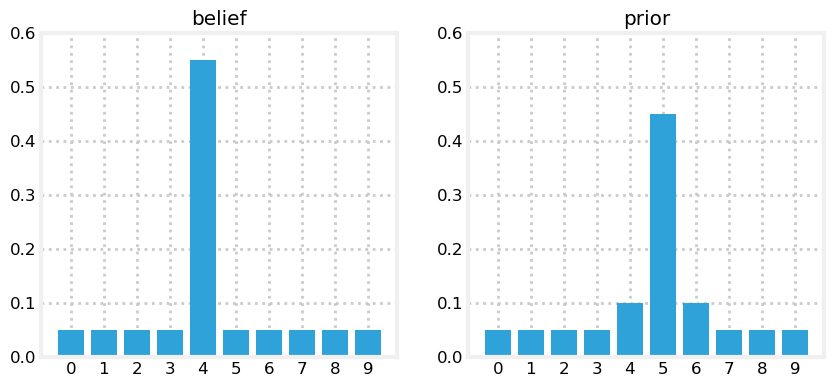

In [21]:
from filterpy.discrete_bayes import predict

belief = [.05, .05, .05, .05, .55, .05, .05, .05, .05, .05]
prior = predict(belief, offset=1, kernel=[.1, .8, .1])
book_plots.plot_belief_vs_prior(belief, prior, ylim=(0,0.6))

除了中间的元素外，所有的元素都不变。位置4和6的值应该是
$$(0.1 \times 0.05)+ (0.8 \times 0.05) + (0.1 \times 0.55) = 0.1$$

位置5应该是 $$(0.1 \times 0.05) + (0.8 \times 0.55)+ (0.1 \times 0.05) = 0.45$$

让我们确保它对大于1的运动和非对称核正确地移动位置。

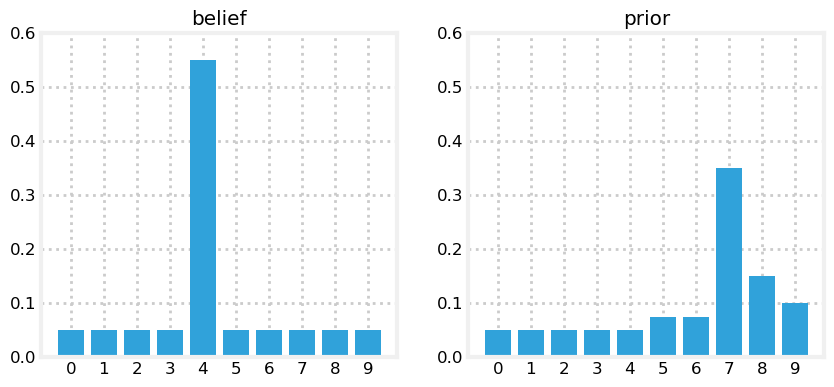

In [22]:
prior = predict(belief, offset=3, kernel=[.05, .05, .6, .2, .1])
book_plots.plot_belief_vs_prior(belief, prior, ylim=(0,0.6))

该位置被正确地移动了3个位置，我们更重视超调的可能性，而不是欠调的可能性，所以这看起来是正确的。

确保你明白我们在做什么。我们预测狗的移动方向，然后对概率进行卷积得到先验。

如果我们不使用概率我们会使用我之前给出的这个方程
$$ \bar x_{k+1} = x_k + f_{\mathbf x}(\bullet)$$

先验，我们对狗的位置的预测，是狗的移动量加上它当前的位置。这只狗在10米，它移动了5米，所以它现在在15米。再简单不过了。但我们用概率来建模，所以方程是:

$$ \bar{ \mathbf x}_{k+1} = \mathbf x_k \ast f_{\mathbf x}(\bullet)$$

我们将当前的概率位置估计与我们认为的狗的移动量的概率估计进行卷积。这是相同的概念，但计算方法略有不同。$\mathbf x$用粗体表示它是一个数字数组。

## 集成测量和移动更新

在预测过程中信息丢失的问题可能会让我们的系统看起来好像很快就会退化到没有信息的状态。然而，每次预测之后都有一个更新，我们在其中将测量纳入估计。更新提高了我们的确定度。更新步骤的输出被输入到下一个预测中。这个预测降低了我们的确定度。预测结果传递到下一次更新中，确定性由于测量值的加入再次增加。

让我们直观地思考一下。考虑一个简单的例子——你正在追踪一只狗，而它却一动不动地坐着。在每次预测中，你都预测他不会移动。你的过滤器很快就会*收敛*到对他位置的准确估计上。然后厨房里的微波炉开了，他就跑了。你不知道这个，所以在下一次预测时，你预测他会在同样的位置。但测量结果却不一样。当你进行测量时，你的信念将沿着走廊走向厨房。在每一个epoch(循环)中，你对他静止不动的信念会越来越小，而你对他以惊人的速度向厨房走来的信念会增加。

这是直觉告诉我们的。数学告诉我们什么?

我们已经为更新和预测步骤编写了程序。我们需要做的就是将一个结果输入到另一个，这样我们就实现了一个狗追踪器!!让我们看看它的表现。我们将输入测量值，就像狗从位置0开始并在每个时间间隔右移一个位置一样。就像在现实世界的应用程序中一样，我们将在不知道他的位置的情况下为所有位置分配相同的概率。

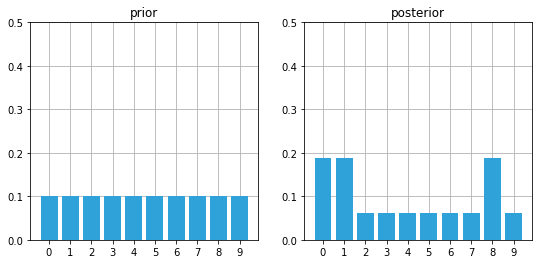

In [47]:
from filterpy.discrete_bayes import update

hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
prior = np.array([.1] * 10)
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

 在第一次更新后，我们为每个门位置分配了高概率，为每个墙位置分配了低概率。

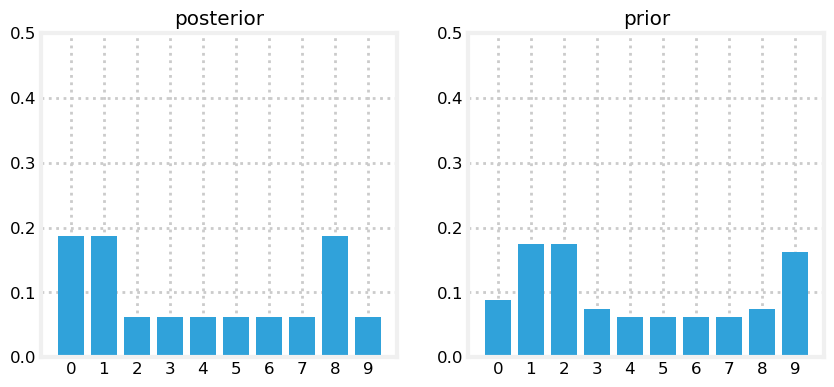

In [24]:
kernel = (.1, .8, .1)
prior = predict(posterior, 1, kernel)
book_plots.plot_prior_vs_posterior(prior, posterior, True, ylim=(0,.5))

预测的步骤将这些概率移向了右边，稍微歪曲了一点。现在我们来看下一种情况。

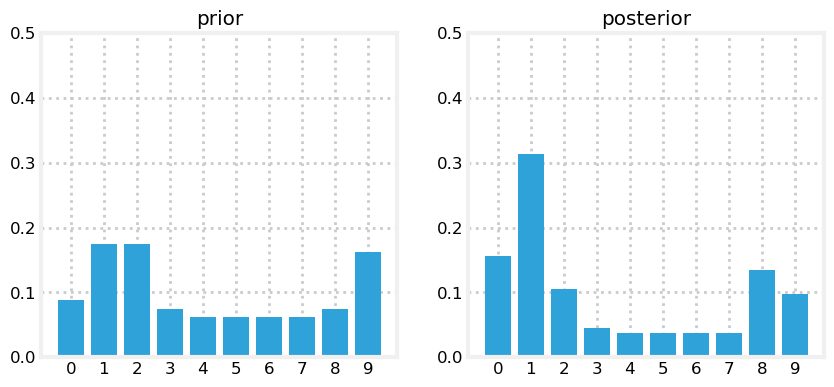

In [25]:
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

注意1号位置的高杆。这与从位置0开始，感知到一扇门，向右移动1，感知到另一扇门的(正确)情况相对应。没有任何其他的情况能像得到这样的结果。现在我们将添加一个更新，然后感知墙。

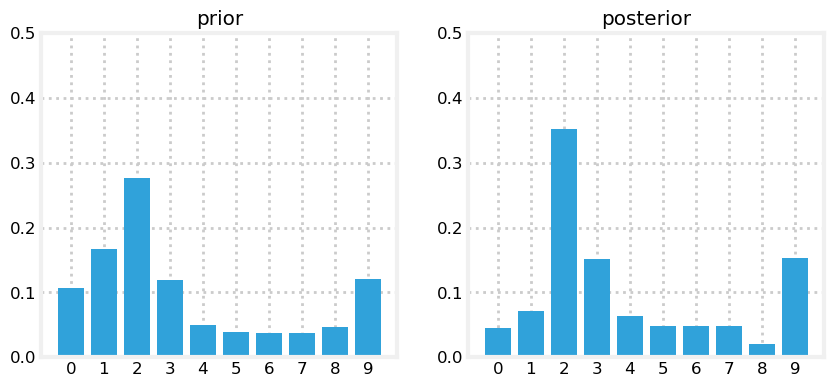

In [26]:
prior = predict(posterior, 1, kernel)
likelihood = lh_hallway(hallway, z=0, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

这是令人兴奋的!我们在第2位有一个非常突出的条形图，值约为35%，它的值是其他地块的两倍多，比上一块地块大了4%，上一块最高的是31%左右。再看一个循环。

In [49]:
prior = predict(posterior, 1, kernel)
likelihood = lh_hallway(hallway, z=0, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

NameError: name 'predict' is not defined

我忽略了一个重要的问题。之前我假设我们有一个用于预测step的运动传感器;然后，当谈到狗和微波炉时，我假设你不知道它突然开始跑了。我提到过，您对狗在奔跑的信念会随着时间的推移而增加，但我没有为此提供任何代码。简而言之，如果我们不直接测量过程模型，我们如何检测和/或评估它的变化?

现在我想忽略这个问题。在后面的章节中，我们将学习这种估计背后的数学;就目前而言，仅仅学习这个算法就已经是一个很大的任务了。解决这个问题是非常重要的，但我们还没有建立足够的必要的数学模型，所以在本章的剩余部分，我们将忽略这个问题，假设我们有一个感知运动的传感器。

## 离散贝叶斯算法

这个图表说明了算法:

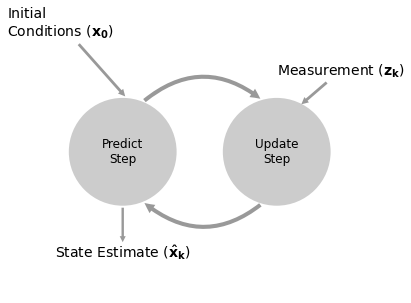

In [50]:
book_plots.predict_update_chart()

这个过滤器是g-h过滤器的一种形式。这里我们使用误差的百分比来隐式地计算$g$和$h$参数。我们可以将离散贝叶斯算法表示为g-h滤波器，但那会模糊这个滤波器的逻辑。

滤波方程为:

$$\begin{aligned} \bar {\mathbf x} &= \mathbf x \ast f_{\mathbf x}(\bullet)\, \, &\text{Predict Step} \\
\mathbf x &= \|\mathcal L \cdot \bar{\mathbf x}\|\, \, &\text{Update Step}\end{aligned}$$

$ mathcal L$是表示似然函数的常用方法，所以我用它。$\|\|$符号表示取规范。我们需要将概率与先验的乘积归一化，以确保$x$是一个和为1的概率分布。

我们可以用伪代码来表示。

**初始化**

    1. 在状态中初始化我们的信念
    
**预测**

    1. 根据系统行为，预测下一个时刻的状态
    2. 调整信念以解释预测中的不确定性
    
**更新**

    1. 获得一个测量值以及对其准确性的相关信念 
    2. 计算测量值匹配每个状态的可能性
    3. 用这种可能性更新状态信念

当我们学习卡尔曼滤波器时我们将使用完全相同的算法;只有计算的细节会有所不同。

这种形式的算法有时被称为“预测校正器”。我们做一个预测，然后纠正它们。

我们生成动画来演示。首先，让我们编写函数来执行过滤并在任意步骤绘制结果。我用黑色标出了门口的位置。先验用橙色表示，后验用蓝色表示。我画了一条粗粗的垂线来表示西蒙的真实位置。这不是过滤器的输出——我们知道西蒙在哪里，因为我们在模拟他的动作。

In [29]:
def discrete_bayes_sim(prior, kernel, measurements, z_prob, hallway):
    posterior = np.array([.1]*10)
    priors, posteriors = [], []
    for i, z in enumerate(measurements):
        prior = predict(posterior, 1, kernel)
        priors.append(prior)

        likelihood = lh_hallway(hallway, z, z_prob)
        posterior = update(likelihood, prior)
        posteriors.append(posterior)
    return priors, posteriors


def plot_posterior(hallway, posteriors, i):
    plt.title('Posterior')
    book_plots.bar_plot(hallway, c='k')
    book_plots.bar_plot(posteriors[i], ylim=(0, 1.0))
    plt.axvline(i % len(hallway), lw=5)    
    
def plot_prior(hallway, priors, i):
    plt.title('Prior')
    book_plots.bar_plot(hallway, c='k')
    book_plots.bar_plot(priors[i], ylim=(0, 1.0), c='#ff8015')
    plt.axvline(i % len(hallway), lw=5)    

def animate_discrete_bayes(hallway, priors, posteriors):
    def animate(step):
        step -= 1
        i = step // 2    
        if step % 2 == 0:
            plot_prior(hallway, priors, i)
        else:
            plot_posterior(hallway, posteriors, i)
    
    return animate

让我们运行过滤器并生成动画。

In [30]:
# change these numbers to alter the simulation
kernel = (.1, .8, .1)
z_prob = 1.0
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

# measurements with no noise
zs = [hallway[i % len(hallway)] for i in range(50)]

priors, posteriors = discrete_bayes_sim(prior, kernel, zs, z_prob, hallway)
interact(animate_discrete_bayes(hallway, priors, posteriors), step=IntSlider(value=1, max=len(zs)*2));

interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

现在我们可以看到结果了。你可以看到先验是如何改变位置和降低确定性，而后验保持在相同的位置和增加确定性，因为它合并了来自测量的信息。我已经用`z_prob = 1.0`行完成了完美的测量;我们将在下一节探讨不完美测量的影响。最后,

另一件需要注意的事情是，当我们站在门口时，我们的估计会变得多么准确，而当我们站在走廊中间时，它又会变得多么不准确。这应该很直观。这里只有几个门道，所以当传感器告诉我们正站在一扇门前时，我们就会对自己的位置更加确定。长时间没有门会降低我们的确认度

## 不良传感器数据的影响

您可能会怀疑上面的结果，因为我总是将正确的传感器数据传递到函数中。然而，我们声明这段代码实现了一个*filter*——它应该过滤掉坏的传感器测量值。它能做到吗?

为了方便编程和可视化，我将改变走廊的布局，主要是交替的门和走廊，并在6个正确的测量上运行算法:

In [31]:
hallway = np.array([1, 0, 1, 0, 0]*2)
kernel = (.1, .8, .1)
prior = np.array([.1] * 10)
zs = [1, 0, 1, 0, 0, 1]
z_prob = 0.75
priors, posteriors = discrete_bayes_sim(prior, kernel, zs, z_prob, hallway)
interact(animate_discrete_bayes(hallway, priors, posteriors), step=IntSlider(value=12, max=len(zs)*2));

interactive(children=(IntSlider(value=12, description='step', max=12), Output()), _dom_classes=('widget-intera…

我们已经确定了从位置0或5开始的可能情况，因为我们看到了门和墙的序列:1,0,1,0,0。现在我注入了一个错误的测量值。下一个测量值应该是0，但结果却是1:

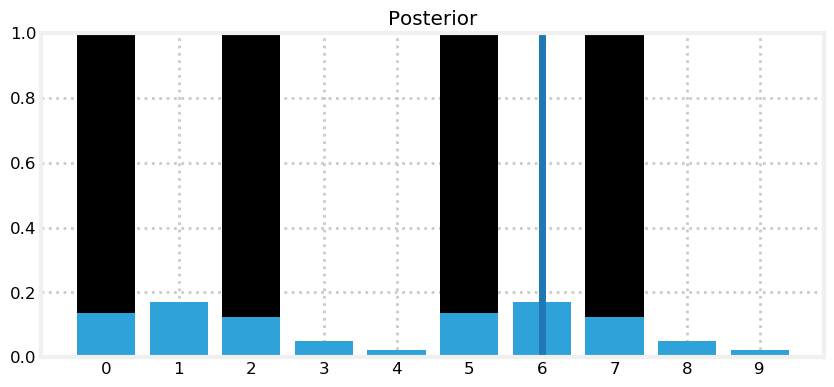

In [32]:
measurements = [1, 0, 1, 0, 0, 1, 1]
priors, posteriors = discrete_bayes_sim(prior, kernel, measurements, z_prob, hallway);
plot_posterior(hallway, posteriors, 6)

这个错误的测量值方法已经严重影响我们的结果。现在让我们继续进行一系列正确的测量。

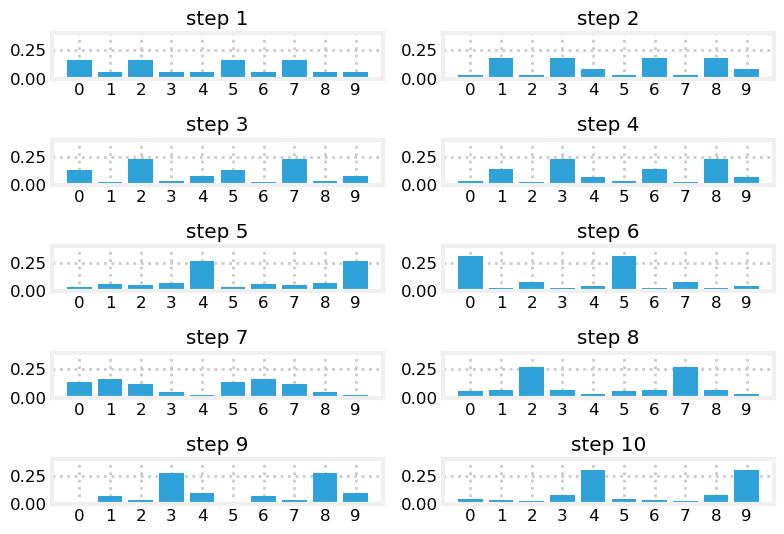

In [33]:
with figsize(y=5.5):
    measurements = [1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
    for i, m in enumerate(measurements):
        likelihood = lh_hallway(hallway, z=m, z_prob=.75)
        posterior = update(likelihood, prior)
        prior = predict(posterior, 1, kernel)
        plt.subplot(5, 2, i+1)
        book_plots.bar_plot(posterior, ylim=(0, .4), title=f'step {i+1}')
    plt.tight_layout()

我们很快过滤掉了错误的传感器读数，收敛在狗狗最可能的位置。

## 缺点和局限性

不要被我选择的例子的简单性所误导。这是一个健壮而完整的过滤器，您可以在现实世界的解决方案中使用该代码。如果你需要一个多模式的的离散滤波器，这个滤波器可以工作。

尽管如此，这个过滤器并不经常使用，因为它有几个限制。绕过这些限制是本书其余章节背后的动机。

第一个问题是规模。我们的狗追踪问题只使用了一个变量$pos$来表示狗的位置。大多数有趣的问题都希望在大空间中跟踪一些东西。实际上，至少我们想要跟踪狗的$(x,y)$坐标，可能还有它的速度$(\dot{x}，\dot{y})$。我们还没有讨论多维情况，但我们使用多维网格来存储每个离散位置的概率，而不是数组。每个`update()`和`predict()`步骤都需要更新网格中的所有值，所以一个简单的四个变量问题将需要$O(n^4)$ running time *每个时间步骤*。现实的过滤器可能有10个或更多的变量要跟踪，导致过高的计算要求。

第二个问题是，过滤器是离散的，但我们生活在一个连续的世界。直方图要求您将滤波器的输出建模为一组离散点。一个100米长的走廊需要10000个位置来模拟1厘米精度的走廊。因此，每次更新和预测操作都需要对10,000种不同的概率进行计算。随着维度的增加，情况会呈指数级恶化。一个100x100 m$^2$的庭院需要1亿个传感器才能达到1厘米的精度。

第三个问题是过滤器是多模式的。在上一个例子中，我们非常相信狗在4号或9号位置。这并不总是一个问题。粒子滤波器，我们将在后面学习，是多模态的，并经常使用，因为这一性质。但想象一下，如果你车上的GPS告诉你，它有40%的确定你在D街，30%确定你在威洛大街。

第四个问题是，它需要测量状态的变化。我们需要一个运动传感器来检测狗的运动。有一些方法可以解决这个问题，但它会使本章的阐述复杂化，所以，鉴于上述问题，我将不再进一步讨论它。

也就是说，如果我有一个小问题，这个技术可以处理，我会选择使用它;实现、调试和理解所有优点是很简单的。

## 跟踪和控制

我们一直在被动地跟踪一个自主运动的物体。但考虑这个非常相似的问题。我正在自动化一个仓库，并希望使用机器人收集客户订单的所有物品。也许最简单的方法是让机器人在火车轨道上行驶。我希望能够给机器人一个目的地，让它到达那里。但是火车轨道和机器人马达并不完美。车轮打滑和不完善的电机意味着机器人不太可能移动到你命令的确切位置。不止一个机器人，我们需要知道它们的位置，这样我们就不会让它们碰撞。

所以我们添加了传感器。也许我们每隔几英尺就在轨道上安装一块磁铁，然后用霍尔传感器来计算有多少块磁铁通过。如果我们数到10个磁铁，那么机器人应该在第10个磁铁处。当然，我们可能会错过一个磁体，也可能会数两次，所以我们必须适应某种程度的误差。我们可以使用前一节的代码来跟踪我们的机器人，因为磁铁计数与门口感应非常相似。

但我们不这样做。我们学会了永远不要丢弃信息。如果你有信息，你应该利用它来改进你的估计。我们遗漏了什么信息?我们知道在每个时刻我们给机器人轮子的控制输入是什么。例如，假设我们每秒钟向机器人发送一次移动命令——向左移动一个单位，向右移动一个单位，或者静止不动。如果我发送命令'向左移动1个单位'，我希望1秒后机器人会在它现在位置的左边移动1个单位。这是一个简化，因为我没有考虑加速度，但我不是试图教控制理论。车轮和马达都不完美。机器人可能在0.9单位或1.2单位之外。

现在整个解决方案很清楚了。我们假设狗一直朝着它之前移动的方向移动。对我的狗来说，这是一个可疑的假设!机器人更容易预测。我们将输入我们发送给机器人的命令，而不是基于行为假设做出可疑的预测!换句话说，当我们调用' predict() '时，我们将传递给机器人的指令动作以及描述该动作可能性的内核。

### 模拟列车行为

我们需要模拟一列不完美的火车。当我们命令它移动时，它有时会犯一个小错误，它的传感器有时会返回错误的值。

In [34]:
class Train(object):

    def __init__(self, track_len, kernel=[1.], sensor_accuracy=.9):
        self.track_len = track_len
        self.pos = 0
        self.kernel = kernel
        self.sensor_accuracy = sensor_accuracy

    def move(self, distance=1):
        """ move in the specified direction
        with some small chance of error"""

        self.pos += distance
        # insert random movement error according to kernel
        r = random.random()
        s = 0
        offset = -(len(self.kernel) - 1) / 2
        for k in self.kernel:
            s += k
            if r <= s:
                break
            offset += 1
        self.pos = int((self.pos + offset) % self.track_len)
        return self.pos

    def sense(self):
        pos = self.pos
         # insert random sensor error
        if random.random() > self.sensor_accuracy:
            if random.random() > 0.5:
                pos += 1
            else:
                pos -= 1
        return pos

这样，我们就可以编写过滤器了。我们将把它放到一个函数中，这样我们就可以在不同的假设下运行它。我假设机器人总是从轨道的起点出发。轨道的长度为10个单位，但可以把它想象成一个长度为10000的轨道，磁铁图案每10个单位重复一次。长度为10的线更容易绘制和检查。

In [35]:
def train_filter(iterations, kernel, sensor_accuracy, 
             move_distance, do_print=True):
    track = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    prior = np.array([.9] + [0.01]*9)
    posterior = prior[:]
    normalize(prior)
    
    robot = Train(len(track), kernel, sensor_accuracy)
    for i in range(iterations):
        # move the robot and
        robot.move(distance=move_distance)

        # peform prediction
        prior = predict(posterior, move_distance, kernel)       

        #  and update the filter
        m = robot.sense()
        likelihood = lh_hallway(track, m, sensor_accuracy)
        posterior = update(likelihood, prior)
        index = np.argmax(posterior)

        if do_print:
            print(f'time {i}: pos {robot.pos}, sensed {m}, at position {track[robot.pos]}')
            conf = posterior[index] * 100
            print(f'        estimated position is {index} with confidence {conf:.4f}%:')            

    book_plots.bar_plot(posterior)
    if do_print:
        print()
        print('final position is', robot.pos)
        index = np.argmax(posterior)
        print('''Estimated position is {} with '''
              '''confidence {:.4f}%:'''.format(
                index, posterior[index]*100))

阅读代码，确保你理解它。我们运行一个没有传感器和运动误差的示例。如果代码是正确的，它应该能够定位机器人没有误差。阅读输出有点乏味，但如果您完全不确定更新/预测周期是如何工作的，请务必仔细阅读它，以巩固您的理解。

time 0: pos 4, sensed 4, at position 4
        estimated position is 4 with confidence 99.9900%:
time 1: pos 8, sensed 8, at position 8
        estimated position is 8 with confidence 100.0000%:
time 2: pos 2, sensed 2, at position 2
        estimated position is 2 with confidence 100.0000%:
time 3: pos 6, sensed 6, at position 6
        estimated position is 6 with confidence 100.0000%:

final position is 6
Estimated position is 6 with confidence 100.0000%:


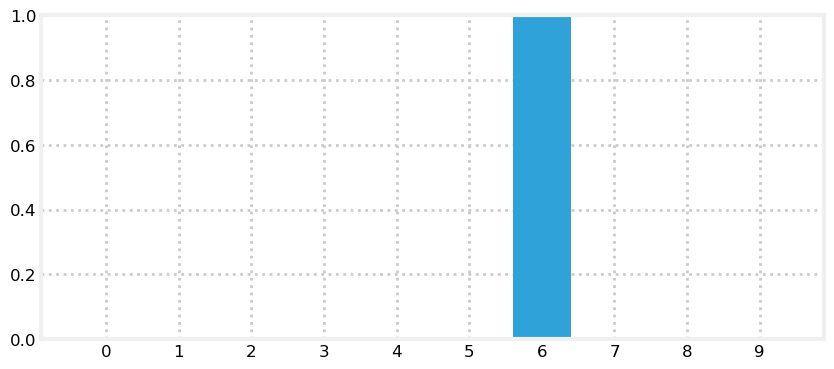

In [36]:
import random

random.seed(3)
np.set_printoptions(precision=2, suppress=True, linewidth=60)
train_filter(4, kernel=[1.], sensor_accuracy=.999,
             move_distance=4, do_print=True)

 我们可以看到代码能够完美地跟踪机器人，所以我们应该有理由相信代码是有效的。现在让我们看看增加误差的情况。

time 0: pos 4, sensed 4, at position 4
        estimated position is 4 with confidence 96.0390%:
time 1: pos 8, sensed 9, at position 8
        estimated position is 9 with confidence 52.1180%:
time 2: pos 3, sensed 3, at position 3
        estimated position is 3 with confidence 88.3993%:
time 3: pos 7, sensed 8, at position 7
        estimated position is 8 with confidence 49.3174%:

final position is 7
Estimated position is 8 with confidence 49.3174%:


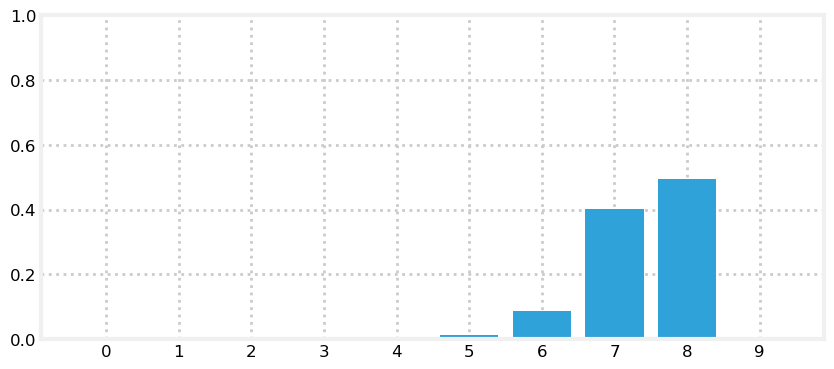

In [37]:
random.seed(5)
train_filter(4, kernel=[.1, .8, .1], sensor_accuracy=.9,
         move_distance=4, do_print=True)

在时间1有一个测量误差，但我们仍然对我们的位置很有信心。

现在让我们运行一个很长的模拟，看看过滤器如何响应误差。

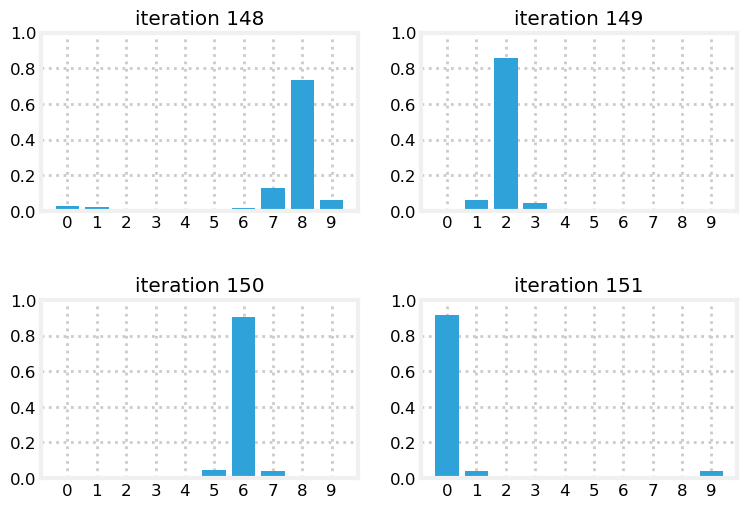

In [38]:
with figsize(y=5.5):
    for i in range (4):
        random.seed(3)
        plt.subplot(221+i)
        train_filter(148+i, kernel=[.1, .8, .1], 
                     sensor_accuracy=.8,
                     move_distance=4, do_print=False)
        plt.title (f'iteration {148 + i}')

我们可以看到，在迭代149中，随着置信度的降低，出现了一个问题。但在几次迭代中，过滤器能够自我纠正，并重新获得对估计位置的信心。

## 贝叶斯定理和全概率定理

在这一章中，我们仅仅通过对每一时刻所掌握的信息进行推理来发展数学。在这个过程中，我们发现了[*贝叶斯定理*](https://en.wikipedia.org/wiki/Bayes%27_theorem)和[*全概率定理*](https://en.wikipedia.org/wiki/Law_of_total_probability)。
 
贝叶斯定理告诉我们如何在已知已知信息的情况下计算事件的概率。

我们用这个概率计算实现了' update() '函数:

$$ \mathtt{posterior} = \frac{\mathtt{likelihood}\times \mathtt{prior}}{\mathtt{normalization\, factor}}$$ 

我们还没有发展数学来讨论贝叶斯，但这就是贝叶斯定理。本书中的每个滤波器都是贝叶斯定理的表达式。在下一章中，我们将进一步发展数学，但在许多方面，这模糊了这个等式中表达的简单概念:

$$ updated\,knowledge = \big\|likelihood\,of\,new\,knowledge\times prior\, knowledge \big\|$$

其中$\| \cdot\|$表示规范化的术语。

我们得出这个结论的原因很简单:一只狗在走廊里走。然而，正如我们将看到的，同样的等式适用于一系列的过滤问题。我们将在以后的每一章中使用这个方程。

同样，`predict()`步骤计算多个可能事件的总概率。这在统计学中被称为*全概率定理*，在发展了一些辅助数学之后，我们将在下一章中讨论它。

现在我需要你们理解贝叶斯定理是一个将新信息整合到现有信息中的公式。

## 总结

代码非常短，但结果令人印象深刻!我们已经实现了一种形式的贝叶斯滤波器。我们已经学会了如何从没有信息开始，从有噪声的传感器获取信息。尽管这一章中的传感器非常嘈杂(例如，大多数传感器的精确度超过80%)，我们还是能很快找到狗最可能出现的位置。我们已经知道，预测步骤总是降低我们的知识，但添加另一个测量，即使它可能有噪声，提高我们的知识，让我们收敛到最可能的结果
 
这本书主要是关于卡尔曼滤波器的。它使用的数学是不同的，但逻辑与本章中使用的完全相同。它使用贝叶斯推理从测量和过程模型的组合形成估计。
 
**如果你能理解本章，你将能够理解和实现卡尔曼滤波器。我再怎么强调也不为过。如果有什么不清楚的地方，请回去重新阅读这一章并尝试一下代码。这本书的其余部分将建立在我们在这里使用的算法之上。如果你不明白为什么这个过滤器会起作用，那么你在其他材料上也不会有什么效果。然而，如果你掌握了基本的洞察力——当我们测量的时候，将概率相乘，当我们更新的时候，改变概率导致一个收敛的解决方案——那么在学习了一点数学之后，你就准备好实现卡尔曼滤波器了。

## 参考文献

 * [1] D. Fox, W. Burgard, and S. Thrun. "Monte carlo localization: Efficient position estimation for mobile robots." In *Journal of Artifical Intelligence Research*, 1999.
 
 http://www.cs.cmu.edu/afs/cs/project/jair/pub/volume11/fox99a-html/jair-localize.html


 * [2] Dieter Fox, et. al. "Bayesian Filters for Location Estimation". In *IEEE Pervasive Computing*, September 2003.
 
 http://swarmlab.unimaas.nl/wp-content/uploads/2012/07/fox2003bayesian.pdf
 
 
 * [3] Sebastian Thrun. "Artificial Intelligence for Robotics".
 
 https://www.udacity.com/course/cs373
 
 
 * [4] Khan Acadamy. "Introduction to the Convolution"
 
 https://www.khanacademy.org/math/differential-equations/laplace-transform/convolution-integral/v/introduction-to-the-convolution
 
 
* [5] Wikipedia. "Convolution"

 http://en.wikipedia.org/wiki/Convolution

* [6] Wikipedia. "Law of total probability"

  http://en.wikipedia.org/wiki/Law_of_total_probability
  
* [7] Wikipedia. "Time Evolution"

 https://en.wikipedia.org/wiki/Time_evolution
 
* [8] We need to rethink how we teach statistics from the ground up
 
 http://www.statslife.org.uk/opinion/2405-we-need-to-rethink-how-we-teach-statistics-from-the-ground-up